# Part 3: Steric height
Andrew Delman. Updated 2024-04-04.

## Objectives

To use ECCO state output to investigate steric height anomalies.

By the end of this tutorial, you will be able to:

* Compute steric height anomaly (SHA)
* Compare SHA with sea surface height
* Use the GSW-Python module to carry out conversions of temperature and salinity to specific volume/density
* Estimate contributions of temperature and salinity to SHA

## Introduction

### Steric height anomaly formulation

Though the density of ocean water changes relatively little compared to the density of air and other gases, even relatively small variations in ocean water density have large impacts on the ocean circulation and sea level variations. Under the conditions of hydrostatic balance (conditions assumed by the MITgcm model configuration run in ECCO v4r4), the vertical gradient of pressure $\partial{p}/\partial{z}$ is a function of density $\rho$ and gravitational acceleration $g$:

$$
\frac{\partial{p}}{\partial{z}} = -{\rho}g
$$

When the density of a parcel water changes, e.g. because its temperature or salinity changes, the parcel of water expands or contracts, and this has an effect on the vertical height of the parcel. This can be expressed in terms of the change in height between two pressure surfaces.

$$
{\Delta}z = \frac{{\Delta}p}{-{\rho}g}
$$

or in integral form

$$
h = \int_{p_r}^{p} \frac{dp}{-{\rho}g}
$$

which can also be notated in terms of the specific volume $V_{sp} \equiv 1/\rho$

$$
h = \int_{p_r}^{p} -\frac{V_{sp}}{g} \, dp
$$

(cf. Gill ch. 7.7, or discussion of thickness in Vallis ch. 2.6)

where $h$ is the steric height at pressure level $p$ relative to some reference pressure level $p_r$. The atmospheric analogue to steric height is called *thickness*, and is commonly used in meteorology and atmospheric science. Generally we are less interested in the value of the steric height itself than in its spatial or temporal variation, so the steric height anomaly $h^{\prime}$ can be defined in terms of a specific volume anomaly $V_{sp}^{\prime}$

$$
h^{\prime} = \int_{p_r}^{p} -\frac{V_{sp}^{\prime}}{g} \, dp
$$

where $V_{sp}^{\prime}$ is the anomaly from the a reference specific volume $V_r$. Sometimes the literature also refers to the geopotential anomaly, which is the steric height anomaly times $g$ (i.e., the above equation without dividing by $g$) and has units m$^2$ s$^{-2}$.



### GSW-Python module

To help carry out computations involving seawater density and related quantities such as specific volume, we will use the [GSW-Python package](https://teos-10.github.io/GSW-Python/), an implementation of the Gibbs SeaWater (GSW) Oceanographic Toolbox of TEOS-10. This especially helpful in computations involving the nonlinear [thermodynamic equation of seawater](https://www.teos-10.org) (also called the equation of state) that relates temperature, salinity, pressure, and density. This equation is quite complicated (the formulation of density for example has 75 terms!), so it is very helpful to have a package to help us with these computations. If you don't have GSW-Python already, you can install it using "*conda install -c conda-forge gsw*" or "*pip install gsw*".


## Open files

For this tutorial, we will need the ECCO datasets with the following ShortNames:

- **ECCO_L4_GEOMETRY_LLC0090GRID_V4R4** (no time dimension; can use any time 1992-2017 in download functions)
- **ECCO_L4_DENS_STRAT_PRESS_LLC0090GRID_MONTHLY_V4R4** (Jan 2000)
- **ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4** (Jan 2000)
- **ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4** (Jan 2000)

To download these datasets to your local machine, you can use the [ecco_download.py](https://raw.githubusercontent.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/master/ECCO-ACCESS/ecco_download.py) module. See the [previous tutorial](https://ecco-v4-python-tutorial.readthedocs.io/Geostrophic_balance.html#Download-the-ECCO-output) or the [ECCO download](https://ecco-v4-python-tutorial.readthedocs.io/Downloading_ECCO_Datasets_from_PODAAC_Python.html) for more info on how to use this module. If you are working on an AWS instance, just set `incloud_access = True` in the 2nd cell below and the datasets will be downloaded or opened remotely using the `ecco_s3_retrieve.py` module.

In [1]:
# first import needed packages
import numpy as np
import xarray as xr
import xmitgcm
import xgcm
import glob
from os.path import expanduser,join
import sys
user_home_dir = expanduser('~')
sys.path.append(join(user_home_dir,'ECCOv4-py'))   # only needed if ecco_v4_py files are stored under this directory
import matplotlib.pyplot as plt
import ecco_v4_py as ecco
from ecco_po_tutorials import *
import gsw

# ShortNames
grid_params_shortname = "ECCO_L4_GEOMETRY_LLC0090GRID_V4R4"
denspress_monthly_shortname = "ECCO_L4_DENS_STRAT_PRESS_LLC0090GRID_MONTHLY_V4R4"
SSH_monthly_shortname = "ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4"
TS_monthly_shortname = "ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4"

In [2]:
# if working in the AWS cloud, set incloud_access = True and run this cell

incloud_access = False

ShortNames_list = [grid_params_shortname,denspress_monthly_shortname,\
                   SSH_monthly_shortname,TS_monthly_shortname]
if incloud_access == True:
    from ecco_s3_retrieve import ecco_podaac_s3_get_diskaware
    # download files to default path ~/Downloads/ECCO_V4r4_PODAAC/
    files_dict = ecco_podaac_s3_get_diskaware(ShortNames=ShortNames_list,\
                                              StartDate='2000-01',EndDate='2000-01',\
                                              max_avail_frac=0.5,\
                                              download_root_dir=None)

### Grid and density/pressure files

If you've completed the previous tutorials you are quite familiar with these files by now.

In [3]:
# download root (parent) directory
download_root_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')

# grid parameters file
grid_params_file = "GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc"
if incloud_access == True:
    grid_params_file_path = files_dict[grid_params_shortname]
else:
    grid_params_file_path = join(download_root_dir,grid_params_shortname,grid_params_file)
ds_grid = xr.open_dataset(grid_params_file_path)

# density/pressure file
if incloud_access == True:
    curr_denspress_file = files_dict[denspress_monthly_shortname]
else:
    download_dir = join(download_root_dir,denspress_monthly_shortname)
    curr_denspress_file = list(glob.glob(join(download_dir,'*2000-01*.nc')))
ds_denspress = xr.open_dataset(curr_denspress_file[0])

### Sea surface height file

To look at the impact of steric height variations, we will also be looking at the actual sea surface height field from ECCOv4. To compare steric height with sea surface height, we of course need to download and retrieve sea surface height output. You can do this by importing the **ecco_download** module and calling the function *ecco_podaac_download* (see the Geostrophic Balance tutorial for an example). Consulting the [variable list](https://raw.githubusercontent.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/master/varlist/v4r4_nctiles_monthly_varlist.txt) for monthly mean output, we find that the datasets containing sea surface height have ShortName ```ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4```. To start, download the granule of that dataset corresponding to January 2000 (2000-01). Once you have this file downloaded, view its structure using the code below.

In [4]:
if incloud_access == True:
    curr_SSH_file = files_dict[SSH_monthly_shortname]
else:
    download_dir = join(download_root_dir,SSH_monthly_shortname)
    curr_SSH_file = list(glob.glob(join(download_dir,'*2000-01*.nc')))
ds_SSH = xr.open_dataset(curr_SSH_file[0])

ds_SSH

<xarray.Dataset> Size: 7MB
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, tile: 13, time: 1, nv: 2, nb: 4)
Coordinates: (12/13)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 8B 2000-01-16T12:00:00
    ...         ...
    YC         (tile, j, i) float32 421kB ...
    XG         (tile, j_g, i_g) float32 421kB ...
    YG         (tile, j_g, i_g) float32 421kB ...
    time_bnds  (time, nv) datetime64[ns] 16B ...
    XC_bnds    (tile, j, i, nb) float32 2MB ...
    YC_bnds    (tile, j, i, nb) float32 2MB ...
Dimensions without coordinates: nv, nb
Data variables:
    SSH        (time, tile, j, i) float32 421kB ...
    SSHIBC     (time, tile, j, i) float32 421kB ...
    SSHNOIBC   (time, tile, j, i) float32 421kB ...
    ETAN       (time, tile, j, i) float32 421kB ...
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            2000-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          2000-01-01T00:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean llc9...
    uuid:                         a7c2a1c4-400c-11eb-9f79-0cc47a3f49c3

Of the data variables here, there are three forms of sea surface height (`SSH`, `SSHNOIBC`, `ETAN`) with slight but important differences, and one variable `SSHIBC` which is a correction for atmospheric pressure effects. Of the three sea surface height variables, the dynamic sea surface height anomaly `SSH` is the most directly related to ocean dynamics (e.g., near-surface geostrophic velocities). The dynamic SSH is also the variable that we would use for comparison with many satellite SSH products such as the [Copernicus](https://data.marine.copernicus.eu/product/SEALEVEL_GLO_PHY_CLIMATE_L4_MY_008_057/description) and [NASA MEaSUREs](https://podaac.jpl.nasa.gov/dataset/SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205) gridded products. Hence `SSH` is the variable that we will use in this tutorial for comparison with the steric height anomaly.

### Temperature and salinity file

Later in this tutorial we will also consider the distinct contributions of temperature and salinity to steric height variations. Fortunately for us, the potential temperature and salinity fields are contained in the same dataset, so for the Jan 2000 temperature and salinity we will only need to download and open one file. Again, use *ecco_podaac_download* to download the file with ShortName ```ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4``` for Jan 2000. Then we can open this file:

In [5]:
if incloud_access == True:
    curr_TS_file = files_dict[TS_monthly_shortname]
else:
    download_dir = join(download_root_dir,TS_monthly_shortname)
    curr_TS_file = list(glob.glob(join(download_dir,'*2000-01*.nc')))
ds_TS = xr.open_dataset(curr_TS_file[0])

ds_TS

<xarray.Dataset> Size: 47MB
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50,
                k_p1: 51, tile: 13, time: 1, nv: 2, nb: 4)
Coordinates: (12/22)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k          (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_u        (k_u) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
    ...         ...
    Zu         (k_u) float32 200B ...
    Zl         (k_l) float32 200B ...
    time_bnds  (time, nv) datetime64[ns] 16B ...
    XC_bnds    (tile, j, i, nb) float32 2MB ...
    YC_bnds    (tile, j, i, nb) float32 2MB ...
    Z_bnds     (k, nv) float32 400B ...
Dimensions without coordinates: nv, nb
Data variables:
    THETA      (time, k, tile, j, i) float32 21MB ...
    SALT       (time, k, tile, j, i) float32 21MB ...
Attributes: (12/62)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               2000-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             2000-01-01T00:00:00
    title:                           ECCO Ocean Temperature and Salinity - Mo...
    uuid:                            f72f9b24-4181-11eb-bf7d-0cc47a3f4871

There are two data variables:

* Potential temperature `THETA` in degrees Celsius, which according to the comment is the temperature a parcel of water would have if moved adiabatically to sea level pressure.
* Salinity `SALT`, which is the salt content of sea water in parts per thousand (units 1e-3, corresponding to g/kg).

## Compute steric height anomaly

Now we will compute steric height anomaly from the density and pressure fields in the ECCOv4r4 output. Note that a [function that computes steric height anomaly](http://www.teos-10.org/pubs/gsw/html/gsw_steric_height.html) is already part of the GSW toolbox for Matlab and some other programming languages, but has not yet been implemented in the GSW-Python module. That's OK, because it is fairly straightforward to implement this function in Python ourselves, especially when ECCO v4r4 already provides density and pressure as outputs. We *can* use GSW-Python to compute the reference specific volume $V_r$, using GSW's definition of $V_r$ as the specific volume at a given pressure level with a conservative temperature of 0 deg C and absolute salinity of 35.16504 g/kg.

### Specific volume anomaly

In [6]:
g = 9.81
rhoConst = 1029.
p_atm = 101325.   # atmospheric pressure at sea surface, in Pa
press = (ds_denspress.PHIHYDcR + (g*(-ds_grid.Z)))*rhoConst   # pressure
press_sea = press - p_atm    # pressure minus mean atmospheric pressure

dens = ds_denspress.RHOAnoma + rhoConst   # in-situ density

# compute standard specific volume and anomalies
S_Ar = 35.16504    # absolute salinity standard for spec. vol., notated as SSO in GSW documentation
T_Cr = 0.    # conservative temperature standard

specvol_standard = gsw.density.specvol(S_Ar,T_Cr,(1.e-4)*press_sea.values)
specvol_anom = 1/dens - specvol_standard

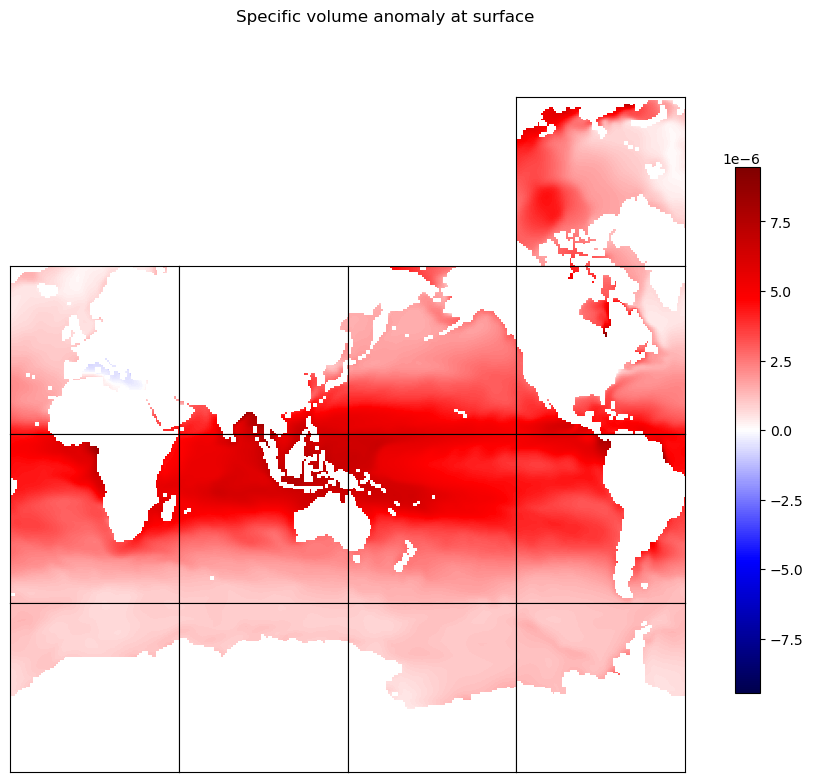

In [7]:
# # plot global tiles map of specific volume anomaly in topmost layer (k=0)

# k index (depth level) to plot
k_plot = 0

# 13 tiles map
curr_obj = ecco.plot_tiles(specvol_anom.isel(k=k_plot).squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=10,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10)
curr_fig = curr_obj[0]
curr_fig.suptitle('Specific volume anomaly at surface')

plt.show()

Notice that surface specific volume anomalies are largest in equatorial regions, particularly in the Indo-Pacific warm pool where surface waters are both very warm and relatively fresh (and therefore have relatively low density). Notice also that the specific volume anomaly is positive nearly everywhere, due to how the anomaly has been defined---based on water of temperature 0 C, at a salinity that is typical of ocean water but saltier than most water that cold.

### Steric height anomaly

Now we'll vertically integrate in pressure coordinates to obtain the steric height anomaly, relative to some reference pressure. In order to compute the integral in pressure coordinates, the pressure values are first computed at the top and bottom interfaces of each grid cell; then the integral is summed over grid cells above the defined reference pressure level.

In [8]:
# pressure reference level to compute steric height
# (in units of dbar, minus 10.1325 dbar atmospheric pressure)
p_r_sea_dbar = 2000.

# # integrate vertically in pressure coordinates

p_r = ((1.e4)*p_r_sea_dbar) + p_atm

# compute pressure at z = 0 (not exactly the ocean surface)
press_z0 = press.isel(k=[0]) - (0.5*dens.isel(k=[0])*g*ds_grid.drF.isel(k=[0]))
press_z0.Z.values = np.array([ds_grid.Zl[0].values,])
# integrate hydrostatic balance downward to get pressure at bottom of grid cells
press_ku = press_z0.values + (dens*g*ds_grid.drF).cumsum("k")
press_ku.Z.values = ds_grid.Zu.values
# create array with pressure at top of grid cells
press_kl = xr.concat([press_z0,press_ku.isel(k=np.arange(len(ds_grid.k) - 1))],dim="k")
press_kl = press_kl.assign_coords(k=ds_grid.k.values)

Now let's choose sea level pressure $p = p_{\rm{atm}}$ (i.e., sea pressure = 0 dbar) as the top limit of our integration, carry out the integration between these two levels, and plot the resulting map.

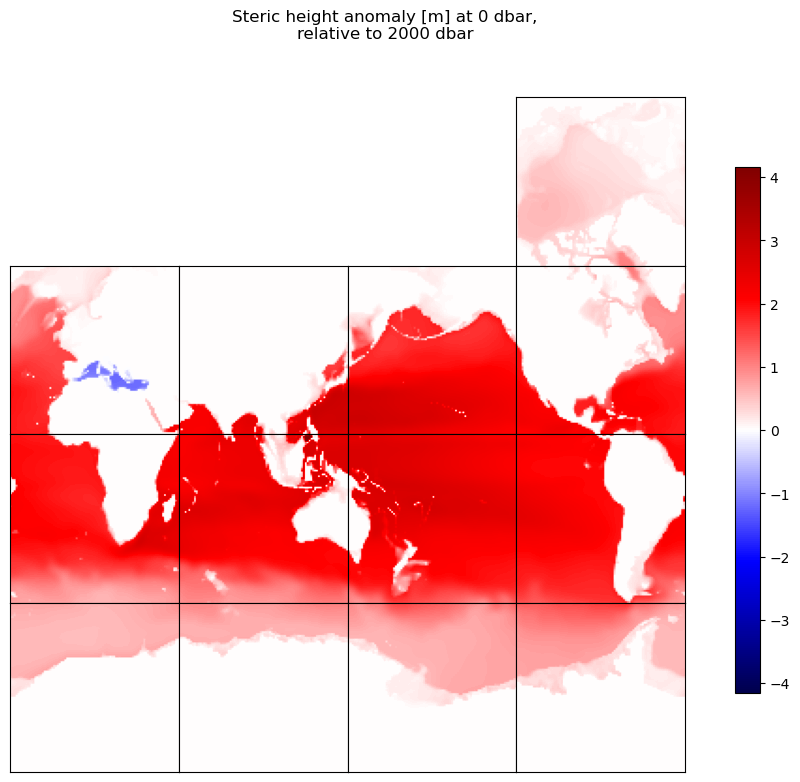

In [9]:
# # compute steric height anomaly at given pressure p_top_sea_dbar, relative to p_r_sea_dbar
p_top_sea_dbar = 0.

p_top = ((1.e4)*p_top_sea_dbar) + p_atm

# compute dp for this integration
dp_integrate =  np.fmax(press_kl,p_top*np.ones(press_kl.shape)) - \
                np.fmin(press_ku,p_r*np.ones(press_ku.shape))
# allow integration above z=0 if p_top is less than p at z=0
p_top_above_z0_mask = (p_top - press_kl.isel(k=0).values < 0)
dp_integrate.isel(k=0).values[p_top_above_z0_mask] = \
                                (p_top - press_ku[:,0,:,:,:].values)[p_top_above_z0_mask]
dp_integrate.values[dp_integrate.values > 0] = 0
steric_hgt_anom = (-(specvol_anom/g)*dp_integrate).sum("k")


# # plot global tiles map of steric height at sea level pressure, i.e. sea pressure = 0 dbar
# # relative to p_r_sea_dbar

# 13 tiles map
curr_obj = ecco.plot_tiles(steric_hgt_anom.squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=10,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10)
curr_fig = curr_obj[0]
curr_fig.suptitle('Steric height anomaly [m] at ' + str(int(p_top_sea_dbar)) + ' dbar,\n'\
                 + 'relative to ' + str(int(p_r_sea_dbar)) + ' dbar')

plt.show()

You can certainly make a few observations from the above map; notice the low steric height anomaly values in the high-salinity Mediterranean Sea for example. But there is a potential problem with the steric height anomaly integration, evident in the abrupt discontinuities across continental slopes (look closely at the areas near the Antarctic Peninsula or Argentina). When the bathymetry is shallower than the reference pressure level, this integration has assumed that the land areas are actually water parcels with the standard specific volume.

To avoid potentially misleading results, let's mask out all areas where the bathymetry is shallower than the $p_r$ pressure level. We'll plot this mask in gray along with a surface land mask in black, and for good measure we will rescale the steric height anomaly so that the global mean of the unmasked areas is removed.

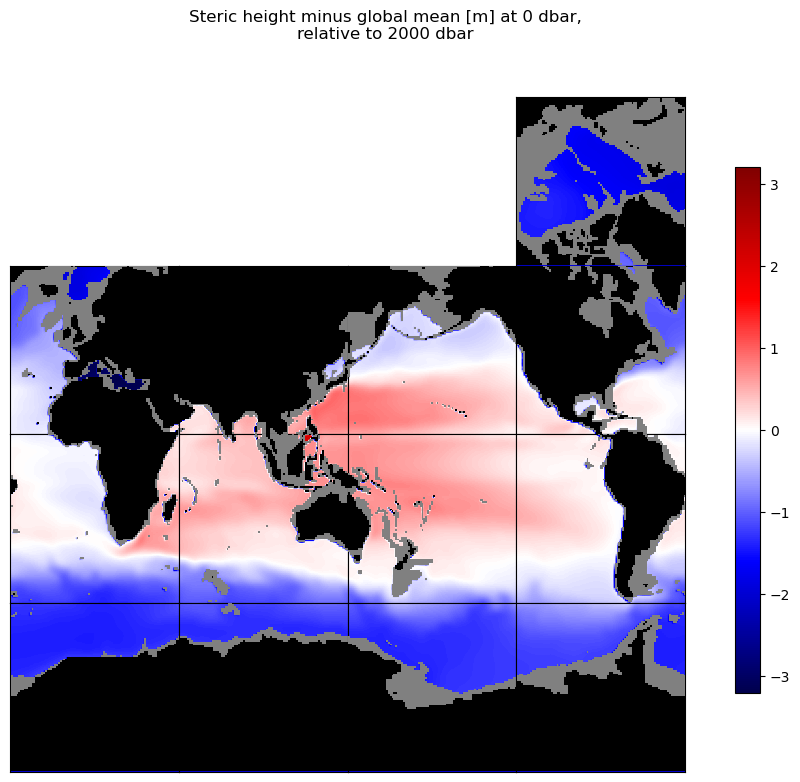

In [10]:
# load land mask (a boolean array) from grid parameters
land_mask = ~ds_grid.maskC

# surface land mask
land_mask_surf = land_mask.isel(k=0)

# mask out areas where sea pressure never reaches the reference pressure
too_shallow_mask = (press_ku.isel(k=-1) < p_r)

# steric height anomaly global mean, excluding masked areas
unmasked = (~land_mask_surf)*(~too_shallow_mask)
steric_hgt_globmean = np.sum(unmasked*ds_grid.rA*steric_hgt_anom)\
                        /np.sum(unmasked*ds_grid.rA)
steric_hgt_minus_globmean = steric_hgt_anom - steric_hgt_globmean


# function to plot a mask in ECCO tiles plots
def plot_mask_ecco_tiles(mask,color):
    """
    Plot mask in global ECCO tiles plot on current axes, 
    given 2-D mask (xarray DataArray) and color (a string, RGB tuple or 3-element NumPy array).
    """
    # loop through tiles to add mask
    tile_order = np.array([-1,-1,-1,6, \
                             2,5,7,10,  \
                             1,4,8,11, \
                             0,3,9,12])
    for idx,curr_ax in enumerate(curr_fig.get_axes()):
        if len(curr_ax.get_images()) > 0:
            # plot land mask
            array_plot = mask.isel(tile=tile_order[idx]).squeeze()
            if tile_order[idx] == 6:
                array_plot = np.rot90(array_plot,2)
            elif tile_order[idx] > 6:
                array_plot = np.rot90(array_plot)
            plot_mask(array_plot,ax=curr_ax,color=color)

# 13 tiles map
curr_obj = ecco.plot_tiles(steric_hgt_minus_globmean.squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=10,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10)
curr_fig = curr_obj[0]
plot_mask_ecco_tiles(land_mask_surf,np.zeros(3,))    # plot land mask
plot_mask_ecco_tiles(too_shallow_mask,np.array([0.5,0.5,0.5]))    # plot too-shallow mask

# add title
curr_fig.suptitle('Steric height minus global mean [m] at ' + str(int(p_top_sea_dbar)) + ' dbar,\n'\
                 + 'relative to ' + str(int(p_r_sea_dbar)) + ' dbar')

plt.show()

## Compare steric height with sea surface height

Of the 4 data variables in the SSH dataset, 3 are forms of sea surface height, just with different corrections applied. The ```SSH``` variable is the dynamic sea surface height anomaly. Importantly, it includes the correction for global mean steric effects, often called the Greatbatch correction; this is essential for tracking steric impacts on sea level over time. The inverted barometer (IB) correction is for the effect of atmospheric pressure on sea level; here we will use the ```SSH``` variable which has the IB correction, and best reflects changes in sea level due to ocean mass and density.

<Figure size 640x480 with 0 Axes>

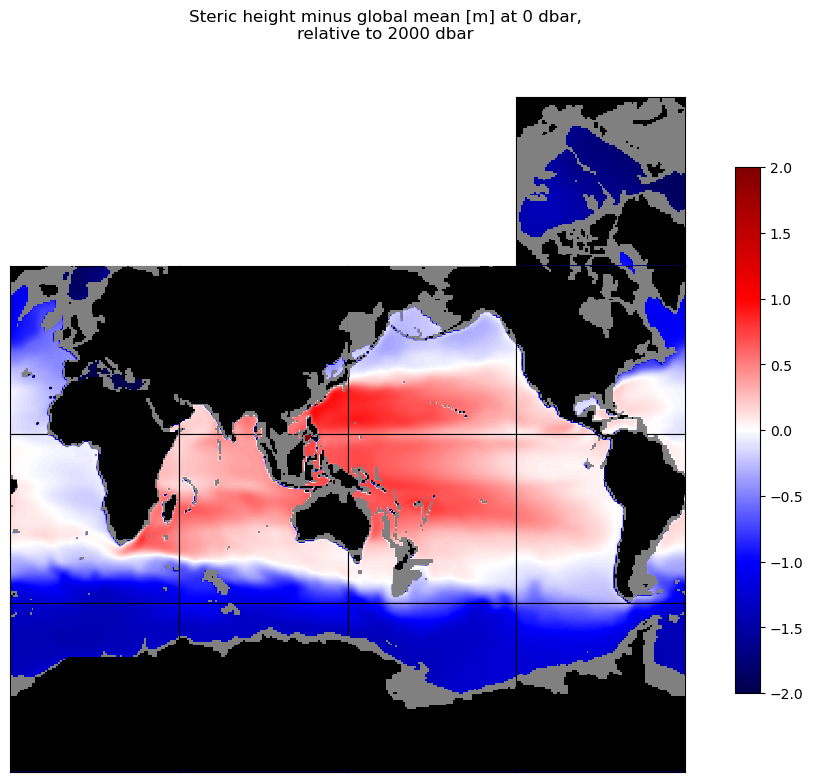

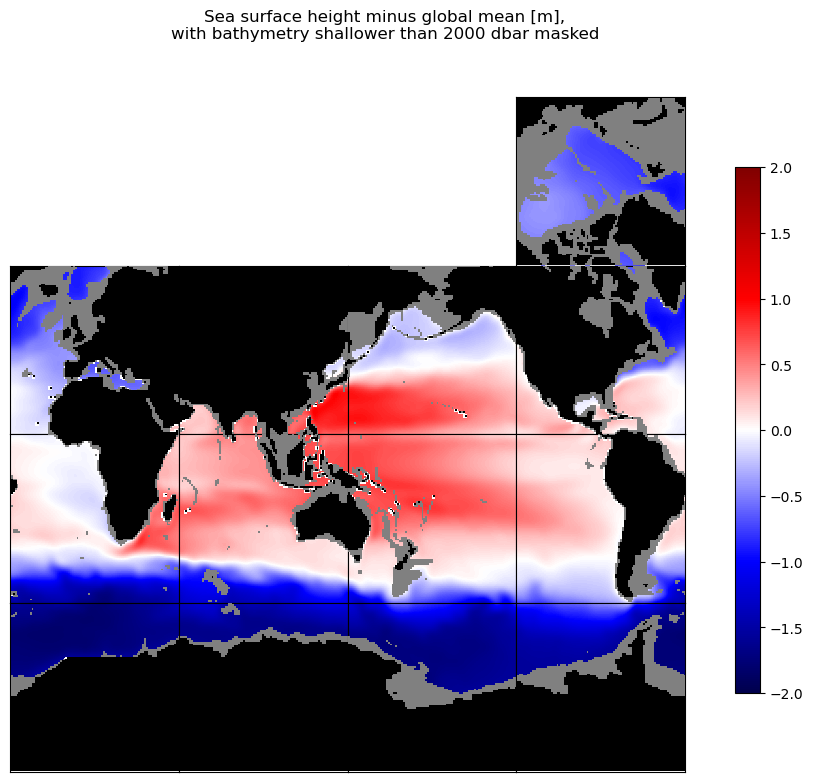

In [11]:
# remove global mean from SSH
SSH_globmean = np.sum((ds_grid.maskC.isel(k=0))*(ds_grid.rA)*ds_SSH.SSH)\
                    /np.sum((ds_grid.maskC.isel(k=0))*(ds_grid.rA))
SSH_minus_globmean = ds_SSH.SSH - SSH_globmean


# plot steric height and SSH minus respective global means

fig = plt.figure(constrained_layout=True)

subfigs = fig.subfigures(2,1)

curr_fig = subfigs[0]
# 13 tiles map
curr_obj = ecco.plot_tiles(steric_hgt_minus_globmean.squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=10,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10,\
                            cmin=-2.,cmax=2.)
curr_fig = curr_obj[0]
plot_mask_ecco_tiles(land_mask_surf,np.zeros(3,))    # plot land mask
plot_mask_ecco_tiles(too_shallow_mask,np.array([0.5,0.5,0.5]))    # plot too-shallow mask
curr_fig.suptitle('Steric height minus global mean [m] at ' + str(int(p_top_sea_dbar)) + ' dbar,\n'\
                 + 'relative to ' + str(int(p_r_sea_dbar)) + ' dbar')

curr_fig = subfigs[1]
# 13 tiles map
curr_obj = ecco.plot_tiles(SSH_minus_globmean.squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=10,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10,\
                            cmin=-2.,cmax=2.)
curr_fig = curr_obj[0]
plot_mask_ecco_tiles(land_mask_surf,np.zeros(3,))    # plot land mask
plot_mask_ecco_tiles(too_shallow_mask,np.array([0.5,0.5,0.5]))    # plot too-shallow mask
curr_fig.suptitle('Sea surface height minus global mean [m],\n' + \
                    'with bathymetry shallower than ' + str(int(p_r_sea_dbar)) + ' dbar masked')

plt.show()

Notice how similar these maps are, even though steric height is only one of the two primary components of sea level variation, and that the steric height map only includes the effect of density variations above 2000 dbar. A little more insight can be gained by taking the difference between the maps above to look at the non-steric height variation:

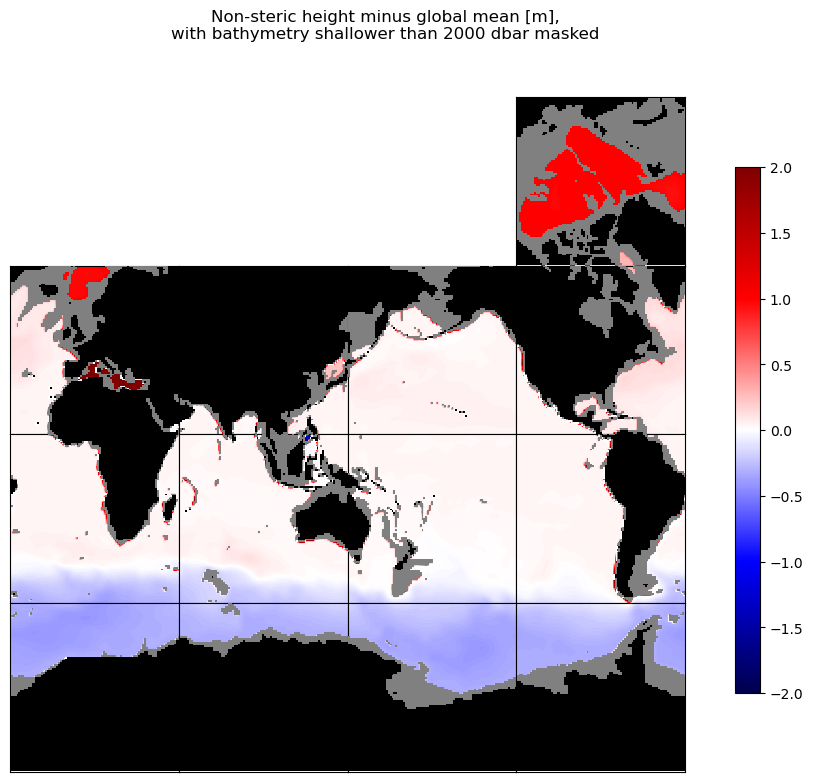

In [12]:
nonsteric_hgt_minus_globmean = SSH_minus_globmean - steric_hgt_minus_globmean

# 13 tiles map
curr_obj = ecco.plot_tiles(nonsteric_hgt_minus_globmean.squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=10,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10,\
                            cmin=-2.,cmax=2.)
curr_fig = curr_obj[0]
plot_mask_ecco_tiles(land_mask_surf,np.zeros(3,))    # plot land mask
plot_mask_ecco_tiles(too_shallow_mask,np.array([0.5,0.5,0.5]))    # plot too-shallow mask
curr_fig.suptitle('Non-steric height minus global mean [m],\n' + \
                  'with bathymetry shallower than ' + str(int(p_r_sea_dbar)) + ' dbar masked')

plt.show()

The map above implies that non-steric effects (or steric effects deeper than 2000 dbar) on the regional variation of sea level are relatively small, with a few notable exceptions. For example, south of the Antarctic Circumpolar Current (ACC), SSH is much lower than might be expected from 0-2000 dbar steric height anomalies, suggesting that either (a) deep ocean steric anomalies must explain the discrepancy, or (b) a gradient in vertically-integrated ocean mass (i.e. deep ocean pressure) is sustained across the ACC. Which explanation do you think it is, and how might we test that hypothesis?

## Thermosteric and halosteric contributions

### Definitions and methods

In the [thermodynamic equation of seawater](https://www.teos-10.org/) or TEOS (also called the equation of state), density is a function of [three parameters](https://teos-10.github.io/GSW-Python/density.html): absolute salinity, conservative temperature, and pressure. The pressure contribution is almost entirely a function of depth and is negligible when considering horizontal variations in density. Since density variations are a major influence on the ocean circulation and sea level, as we have seen in this tutorial, oceanographers are interested in the distinct contributions that temperature and salinity make to density. These contributions are called the *thermosteric* and *halosteric* contributions respectively.

For small variations in temperature $T$ or salinity $S$, the relative contributions of each can be expressed as a linear approximation (e.g., Gill and Niiler 1973):

$$
{\Delta}\rho = \frac{\partial{\rho}}{\partial{S}}{\Delta}S + \frac{\partial{\rho}}{\partial{T}}{\Delta}T \equiv \rho\left({\beta}{\Delta}S - {\alpha}{\Delta}T\right)
$$

where we have defined a saline contraction coefficient $\beta \equiv (1/\rho)\partial{\rho}/\partial{S}$ and thermal expansion coefficient $\alpha \equiv -(1/\rho)\partial{\rho}/\partial{T}$ as the local derivatives of density with respect to salinity and temperature respectively. $\alpha$ and $\beta$ are unitless coefficients, and they can also be expressed in terms of specific volume $\alpha = (1/{V_{sp}})\partial{V_{sp}}/\partial{T}$ and $\beta = (1/{V_{sp}})\partial{V_{sp}}/\partial{S}$. These linear approximations are particularly useful in computing the effect of temperature and salinity on density gradients in a small area; on global scales the nonlinearity of TEOS may lead to distortions using this approximation.

To illustrate this, let's compute the thermosteric and halosteric contributions in two ways. In the first method, we will compute specific volume anomaly for each component using the linear approximations $\alpha$ and $\beta$ around the reference specific volume $V_r$ (corresponding to a conservative temperature of $T_{Cr}$ = 0 deg C and absolute salinity of $S_{Ar}$ = 35.16504 g/kg).

$$
{\rm Thermosteric}\,V_{sp}^{\prime} = {V_r}{\alpha_r}\left(T_C - T_{Cr}\right)
$$

$$
{\rm Halosteric}\,V_{sp}^{\prime} = -{V_r}{\beta_r}\left(S_A - S_{Ar}\right)
$$

where the subscript $_r$ indicates values computed at the reference $T_{Cr}$ and $S_{Ar}$.

In the second method, we will compute specific volume anomalies at each location while substituting in $S_{Ar} \rightarrow S_A$ when computing the thermosteric contribution and $T_{Cr} \rightarrow T_C$ when computing the halosteric contribution. In this way the specific volume anomaly is associated only with a difference in temperature or salinity respectively.

$$
{\rm Thermosteric}\,V_{sp}^{\prime} = V_{sp}\left\{S_{Ar},T_C,p\right\} - V_{sp}\left\{S_{Ar},T_{Cr},p\right\}
$$

$$
{\rm Halosteric}\,V_{sp}^{\prime} = V_{sp}\left\{S_A,T_{Cr},p\right\} - V_{sp}\left\{S_{Ar},T_{Cr},p\right\}
$$

The difference between these two methods gives a sense of the impact of the nonlinearity of TEOS on the steric height anomaly.

### Conservative temperature

The TEOS framework provides a number of [different definitions of salinity](https://www.teos-10.org/pubs/TEOS-10_Primer.pdf), and it is a little ambiguous which of these corresponds most closely to the salinity field `SALT` from the ECCOv4 output. However, absolute salinity $S_A$ is the salinity measure that directly impacts density, and since `SALT` is used to compute density in the MITgcm, we will assume that `SALT` corresponds to $S_A$. For temperature, it is clear from the variable's comment that `THETA` corresponds to potential temperature, while TEOS takes *conservative* temperature as an input. The difference between the two is not very large, but reflects the impact of salt concentrate on the thermal energy in seawater.

GSW-Python provides [a number of conversion functions](https://teos-10.github.io/GSW-Python/conversions.html), including one to convert from potential temperature to conservative temperature.

In [13]:
# look at syntax of potential -> conservative temperature conversion function
help(gsw.conversions.CT_from_pt)

Help on function CT_from_pt in module gsw._wrapped_ufuncs:

CT_from_pt(SA, pt)
    Calculates Conservative Temperature of seawater from potential
    temperature (whose reference sea pressure is zero dbar).
    
    Parameters
    ----------
    SA : array-like
        Absolute Salinity, g/kg
    pt : array-like
        Potential temperature referenced to a sea pressure, degrees C
    
    Returns
    -------
    CT : array-like, deg C
        Conservative Temperature (ITS-90)



See that the function takes absolute salinity and potential temperature as inputs. Now let's use the function, and plot the difference between potential and conservative temperature globally in the top (surface) layer. We'll also plot a map of salinity in the surface layer, and you'll see why.

<Figure size 640x480 with 0 Axes>

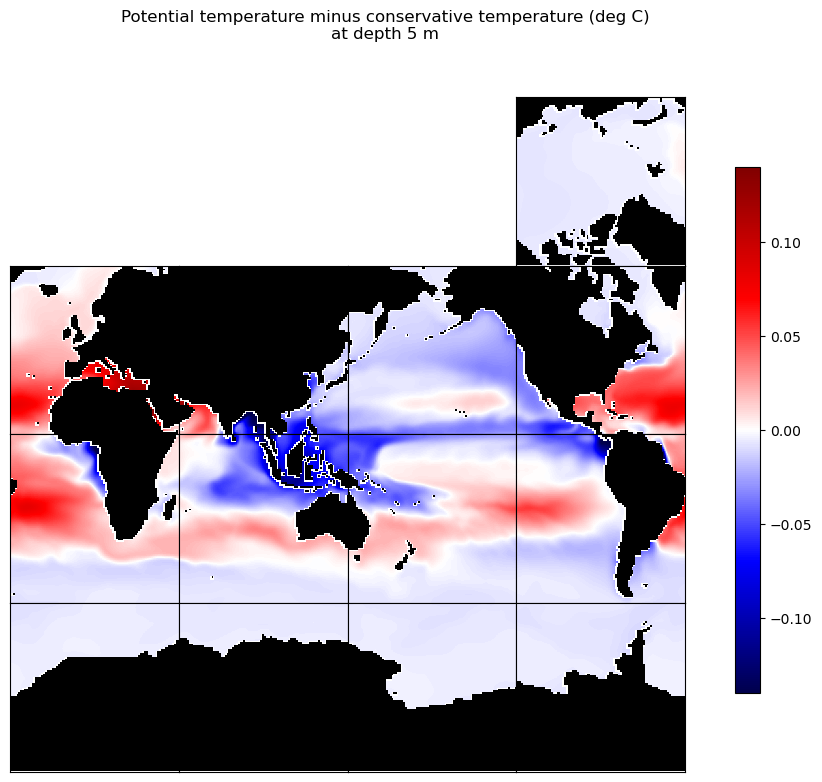

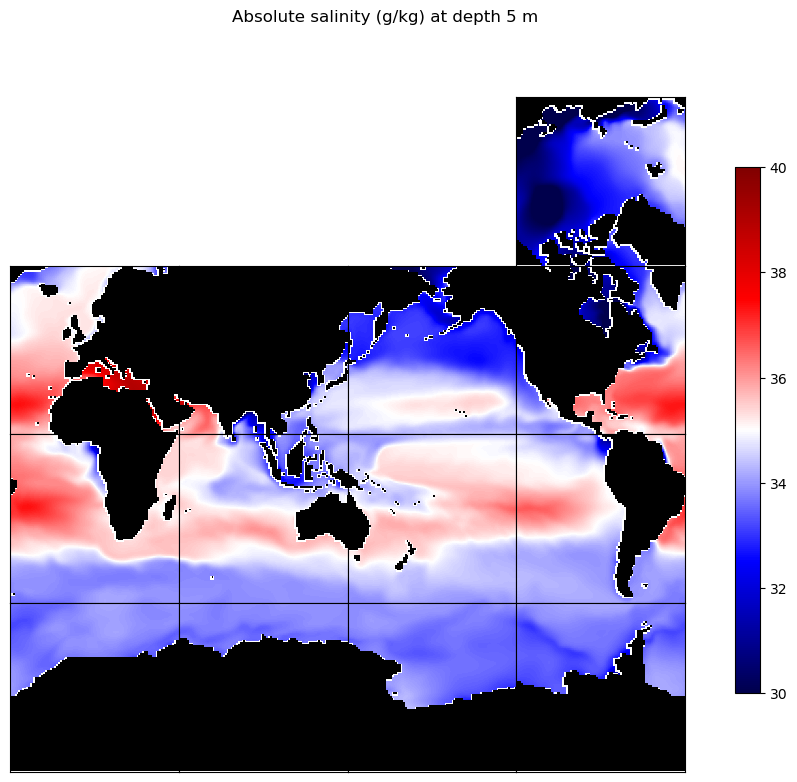

In [14]:
temp_pot = ds_TS.THETA
sal_abs = ds_TS.SALT

# compute conservative temperature
temp_cons = gsw.conversions.CT_from_pt(sal_abs,temp_pot)

# plot the difference between conservative and potential temperature at the surface
pot_minus_cons = temp_pot - temp_cons

k_plot = 0


# 13 tiles maps

fig = plt.figure(constrained_layout=True)

subfigs = fig.subfigures(2,1)

curr_fig = subfigs[0]
curr_obj = ecco.plot_tiles(pot_minus_cons.isel(k=k_plot).squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=10,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10,\
                            cmin=-0.14,cmax=0.14)
curr_fig = curr_obj[0]
plot_mask_ecco_tiles(land_mask_surf,np.zeros(3,))    # plot land mask
curr_fig.suptitle('Potential temperature minus conservative temperature (deg C)\n' + \
                  'at depth ' + str(int(-ds_TS.Z.isel(k=k_plot))) + ' m')

curr_fig = subfigs[1]
curr_obj = ecco.plot_tiles(sal_abs.isel(k=k_plot).squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=10,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10,\
                            cmin=30.,cmax=40.)
curr_fig = curr_obj[0]
plot_mask_ecco_tiles(land_mask_surf,np.zeros(3,))    # plot land mask
curr_fig.suptitle('Absolute salinity (g/kg) ' + \
                  'at depth ' + str(int(-ds_TS.Z.isel(k=k_plot))) + ' m')

plt.show()

We know that conservative temperature can be computed from potential temperature and absolute salinity, so the consistency of the maps above is not a surprise. Still, it helps illustrate the effect of salinity on the temperature (vs. the heat content) of seawater.

### Method 1: Using expansion/contraction coefficients

Now we will compute the thermosteric and halosteric contributions to steric height anomaly using the thermal expansion coefficient $\alpha$ and the saline contraction coefficient $\beta$, as linearized around the reference $T_{Cr}$ and $S_{Ar}$. GSW-Python has functions to compute these coefficients.

<Figure size 640x480 with 0 Axes>

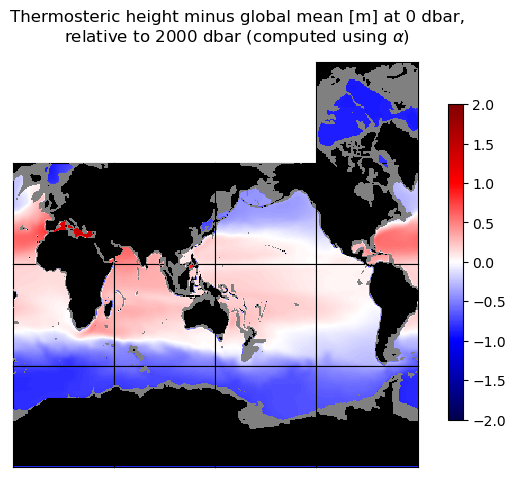

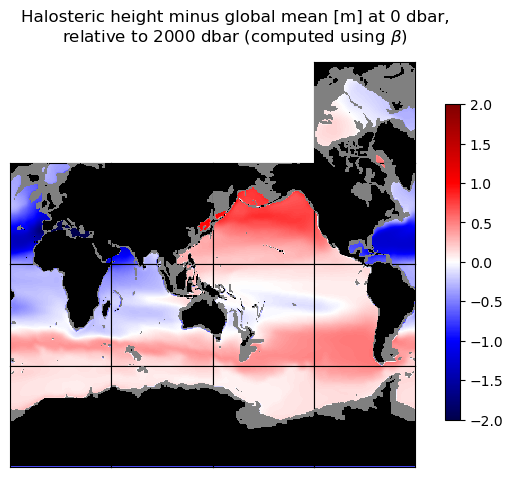

In [15]:
# thermal expansion coefficient alpha at T_Cr, S_Ar
alpha = gsw.density.alpha(S_Ar,T_Cr,(1.e-4)*press_sea.values)

# saline contraction coefficient beta at T_Cr, S_Ar
beta = gsw.density.beta(S_Ar,T_Cr,(1.e-4)*press_sea.values)

# thermosteric and halosteric specific volume anomalies
specvol_thermo_anom_linear = specvol_standard*alpha*(temp_cons - T_Cr)
specvol_halo_anom_linear = -specvol_standard*beta*(sal_abs - S_Ar)

# integrate vertically to obtain height anomalies
thermosteric_hgt_anom_linear = (-(specvol_thermo_anom_linear/g)*dp_integrate).sum("k")
halosteric_hgt_anom_linear = (-(specvol_halo_anom_linear/g)*dp_integrate).sum("k")


# contribution global means, excluding masked areas
thermosteric_hgt_linear_globmean = np.sum(unmasked*ds_grid.rA*thermosteric_hgt_anom_linear)\
                                            /np.sum(unmasked*ds_grid.rA)
halosteric_hgt_linear_globmean = np.sum(unmasked*ds_grid.rA*halosteric_hgt_anom_linear)\
                                            /np.sum(unmasked*ds_grid.rA)

# subtract global means
thermosteric_hgt_minus_globmean_linear = thermosteric_hgt_anom_linear \
                                        - thermosteric_hgt_linear_globmean
halosteric_hgt_minus_globmean_linear = halosteric_hgt_anom_linear \
                                        - halosteric_hgt_linear_globmean

# sum of two contributions
contribsum_hgt_minus_globmean_linear = thermosteric_hgt_minus_globmean_linear + \
                                    halosteric_hgt_minus_globmean_linear


# plot thermosteric and halosteric contributions (linear approximations),
# plus their sum and the full steric height anomaly

fig = plt.figure(constrained_layout=True)

subfigs = fig.subfigures(2,1)

curr_fig = subfigs[0]
# 13 tiles map
curr_obj = ecco.plot_tiles(thermosteric_hgt_minus_globmean_linear.squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=6,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10,\
                            cmin=-2.,cmax=2.)
curr_fig = curr_obj[0]
plot_mask_ecco_tiles(land_mask_surf,np.zeros(3,))    # plot land mask
plot_mask_ecco_tiles(too_shallow_mask,np.array([0.5,0.5,0.5]))    # plot too-shallow mask
curr_fig.suptitle('Thermosteric height minus global mean [m] at ' + str(int(p_top_sea_dbar)) + ' dbar,\n'\
                 + 'relative to ' + str(int(p_r_sea_dbar)) + ' dbar (computed using $\\alpha$)')

curr_fig = subfigs[1]
# 13 tiles map
curr_obj = ecco.plot_tiles(halosteric_hgt_minus_globmean_linear.squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=6,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10,\
                            cmin=-2.,cmax=2.)
curr_fig = curr_obj[0]
plot_mask_ecco_tiles(land_mask_surf,np.zeros(3,))    # plot land mask
plot_mask_ecco_tiles(too_shallow_mask,np.array([0.5,0.5,0.5]))    # plot too-shallow mask
curr_fig.suptitle('Halosteric height minus global mean [m] at ' + str(int(p_top_sea_dbar)) + ' dbar,\n'\
                 + 'relative to ' + str(int(p_r_sea_dbar)) + ' dbar (computed using $\\beta$)')

plt.show()

<Figure size 640x480 with 0 Axes>

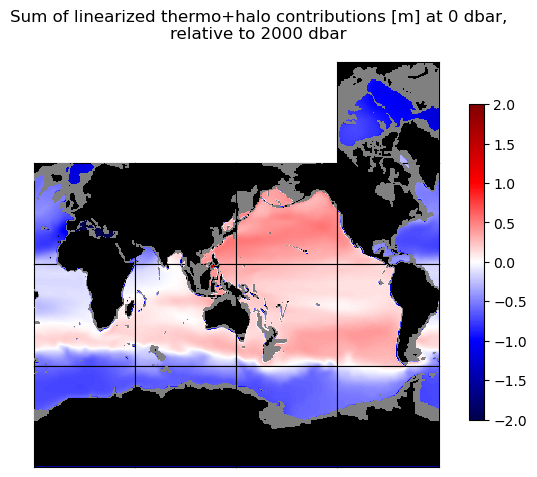

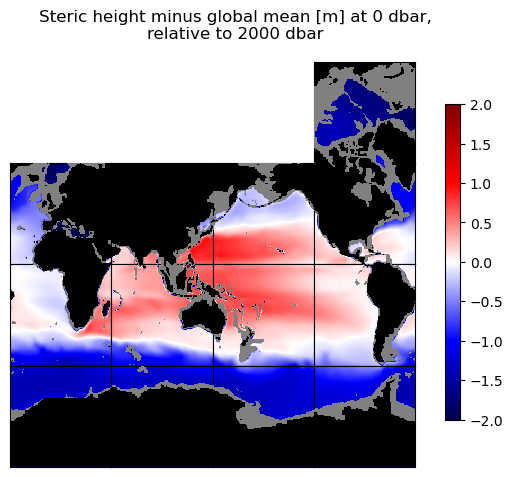

In [16]:
# plot sum of contributions vs. full steric height anomaly

fig = plt.figure(constrained_layout=True)

subfigs = fig.subfigures(2,1)

curr_fig = subfigs[0]
# 13 tiles map
curr_obj = ecco.plot_tiles(contribsum_hgt_minus_globmean_linear.squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=6,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10,\
                            cmin=-2.,cmax=2.)
curr_fig = curr_obj[0]
plot_mask_ecco_tiles(land_mask_surf,np.zeros(3,))    # plot land mask
plot_mask_ecco_tiles(too_shallow_mask,np.array([0.5,0.5,0.5]))    # plot too-shallow mask
curr_fig.suptitle('Sum of linearized thermo+halo contributions [m] at ' + str(int(p_top_sea_dbar)) + ' dbar,\n'\
                 + 'relative to ' + str(int(p_r_sea_dbar)) + ' dbar')

curr_fig = subfigs[1]
# 13 tiles map
curr_obj = ecco.plot_tiles(steric_hgt_minus_globmean.squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=6,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10,\
                            cmin=-2.,cmax=2.)
curr_fig = curr_obj[0]
plot_mask_ecco_tiles(land_mask_surf,np.zeros(3,))    # plot land mask
plot_mask_ecco_tiles(too_shallow_mask,np.array([0.5,0.5,0.5]))    # plot too-shallow mask
curr_fig.suptitle('Steric height minus global mean [m] at ' + str(int(p_top_sea_dbar)) + ' dbar,\n'\
                 + 'relative to ' + str(int(p_r_sea_dbar)) + ' dbar')

plt.show()

The first two maps show a thermosteric contribution that is largely latitude-dependent (no surprise), and a halosteric contribution that is very different in the Pacific (a fresher ocean) vs. the Atlantic and Indian oceans (more salty).

These patterns together help explain the full steric height variation in the last map above, though the sum of the two contributions obviously does not explain all of the full steric height variation.

### Method 2: Using specific volume differences

Now let's compute the thermosteric and halosteric contributions again, using the second method ($V_{sp}$ differences associated with temperature or salinity variations). This should account for at least some of the nonlinear aspects of TEOS.

<Figure size 640x480 with 0 Axes>

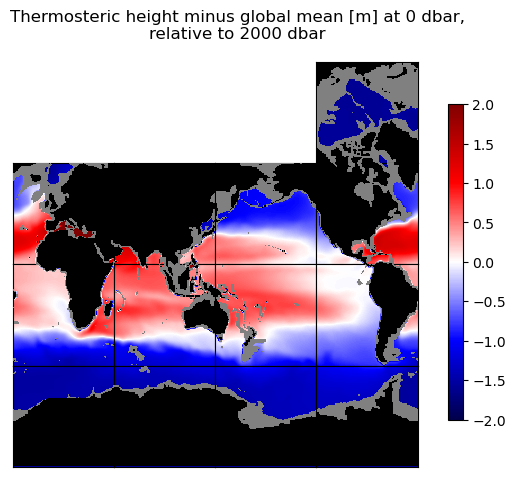

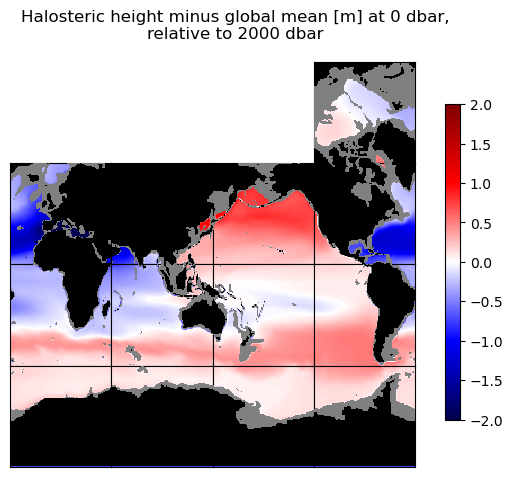

In [17]:
# compute specific volume anomalies due to temperature and salinity variations
specvol_thermo_anom = gsw.density.specvol(S_Ar,temp_cons,(1.e-4)*press_sea.values) - specvol_standard
specvol_halo_anom = gsw.density.specvol(sal_abs,T_Cr,(1.e-4)*press_sea.values) - specvol_standard

# integrate vertically to obtain height anomalies
thermosteric_hgt_anom = (-(specvol_thermo_anom/g)*dp_integrate).sum("k")
halosteric_hgt_anom = (-(specvol_halo_anom/g)*dp_integrate).sum("k")


# contribution global means, excluding masked areas
thermosteric_hgt_globmean = np.sum(unmasked*ds_grid.rA*thermosteric_hgt_anom)\
                                            /np.sum(unmasked*ds_grid.rA)
halosteric_hgt_globmean = np.sum(unmasked*ds_grid.rA*halosteric_hgt_anom)\
                                            /np.sum(unmasked*ds_grid.rA)

# subtract global means
thermosteric_hgt_minus_globmean = thermosteric_hgt_anom \
                                        - thermosteric_hgt_globmean
halosteric_hgt_minus_globmean = halosteric_hgt_anom \
                                        - halosteric_hgt_globmean

# sum of two contributions
contribsum_hgt_minus_globmean = thermosteric_hgt_minus_globmean + \
                                    halosteric_hgt_minus_globmean


# plot thermosteric and halosteric contributions (linear approximations),
# plus their sum and the full steric height anomaly

fig = plt.figure(constrained_layout=True)

subfigs = fig.subfigures(2,1)

curr_fig = subfigs[0]
# 13 tiles map
curr_obj = ecco.plot_tiles(thermosteric_hgt_minus_globmean.squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=6,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10,\
                            cmin=-2.,cmax=2.)
curr_fig = curr_obj[0]
plot_mask_ecco_tiles(land_mask_surf,np.zeros(3,))    # plot land mask
plot_mask_ecco_tiles(too_shallow_mask,np.array([0.5,0.5,0.5]))    # plot too-shallow mask
curr_fig.suptitle('Thermosteric height minus global mean [m] at ' + str(int(p_top_sea_dbar)) + ' dbar,\n'\
                 + 'relative to ' + str(int(p_r_sea_dbar)) + ' dbar')

curr_fig = subfigs[1]
# 13 tiles map
curr_obj = ecco.plot_tiles(halosteric_hgt_minus_globmean.squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=6,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10,\
                            cmin=-2.,cmax=2.)
curr_fig = curr_obj[0]
plot_mask_ecco_tiles(land_mask_surf,np.zeros(3,))    # plot land mask
plot_mask_ecco_tiles(too_shallow_mask,np.array([0.5,0.5,0.5]))    # plot too-shallow mask
curr_fig.suptitle('Halosteric height minus global mean [m] at ' + str(int(p_top_sea_dbar)) + ' dbar,\n'\
                 + 'relative to ' + str(int(p_r_sea_dbar)) + ' dbar')

plt.show()

And now let's compare the sum of the contributions with the full steric height anomaly again.

<Figure size 640x480 with 0 Axes>

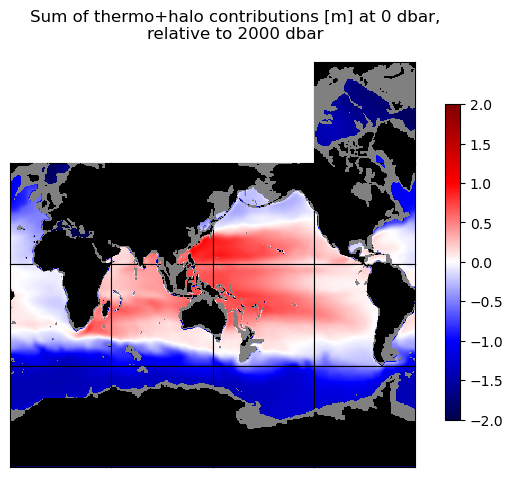

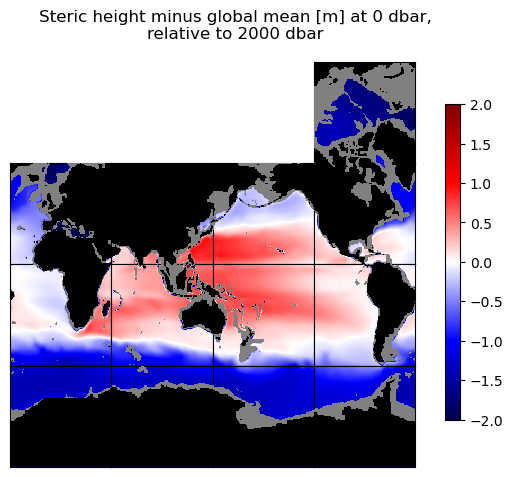

In [18]:
# plot sum of contributions vs. full steric height anomaly

fig = plt.figure(constrained_layout=True)

subfigs = fig.subfigures(2,1)

curr_fig = subfigs[0]
# 13 tiles map
curr_obj = ecco.plot_tiles(contribsum_hgt_minus_globmean.squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=6,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10,\
                            cmin=-2.,cmax=2.)
curr_fig = curr_obj[0]
plot_mask_ecco_tiles(land_mask_surf,np.zeros(3,))    # plot land mask
plot_mask_ecco_tiles(too_shallow_mask,np.array([0.5,0.5,0.5]))    # plot too-shallow mask
curr_fig.suptitle('Sum of thermo+halo contributions [m] at ' + str(int(p_top_sea_dbar)) + ' dbar,\n'\
                 + 'relative to ' + str(int(p_r_sea_dbar)) + ' dbar')

curr_fig = subfigs[1]
# 13 tiles map
curr_obj = ecco.plot_tiles(steric_hgt_minus_globmean.squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=6,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10,\
                            cmin=-2.,cmax=2.)
curr_fig = curr_obj[0]
plot_mask_ecco_tiles(land_mask_surf,np.zeros(3,))    # plot land mask
plot_mask_ecco_tiles(too_shallow_mask,np.array([0.5,0.5,0.5]))    # plot too-shallow mask
curr_fig.suptitle('Steric height minus global mean [m] at ' + str(int(p_top_sea_dbar)) + ' dbar,\n'\
                 + 'relative to ' + str(int(p_r_sea_dbar)) + ' dbar')

plt.show()

It looks like this time we did a much better job of accounting for the full steric height variation!

## Exercises

1. Using the `lon_depth_along_lat` function defined in the thermal wind tutorial (and already imported here as part of the `ecco_py_tutorials` module), plot steric height anomalies and the thermosteric and halosteric contributions along a line of latitude around the globe. Since these anomalies have been vertically integrated, you may need to re-add the `k` dimension to the DataArrays before using this function; you can use [expand_dims](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.expand_dims.html):

      {array_name} = {array_name}.expand_dims(dim={"k":ds_grid.Z.values[0]},axis=-4)

      How do the relative contributions of temperature and salinity look different when following a line of latitude? You can also see how the reference pressure impacts the result by re-running this notebook with a different `p_r_sea_dbar` as input.

1. Look at the change in steric height over time. Download the monthly density/pressure, SSH, and temperature/salinity files for each month in the year 1992, open the files using open_mfdataset, and average them in 1992 (the first year in the ECCOv4 output). Do the same for the year 2017 (the last year in the ECCOv4 output). Create maps similar to the ones in this tutorial, but for the (2017 mean) - (1992 mean). How did the steric, thermosteric, and halosteric contributions change over this 25-year period, and how do they compare to the change in dynamic SSH?

1. For this exercise you'll download the density/pressure, SSH, and temperature/salinity files for the entire period 1992 through 2017. Plot time series of the global mean steric, thermosteric, and halosteric height alongside dynamic SSH. For extra credit, remove the seasonal cycle (by subtracting January means, February means, etc.) to make the longer time scale changes clearer.

## References

Gill, A.E. (1982). ***Atmosphere-Ocean Dynamics***. Academic Press, Elsevier.

Gill, A.E. & P.P. Niiler (1973). The theory of the seasonal variability in the ocean. *Deep Sea Research and Oceanographic Abstracts*, **20(2)**, 141-177. https://doi.org/10.1016/0011-7471(73)90049-1.

Vallis, G.K. (2006). ***Atmospheric and Oceanic Fluid Dynamics***. Cambridge University Press.